# Cat vs Dog Classifier

## Final Project for STAD68 

### Task

Build a cat vs dog classifier with higher accuracy rate by applying Linear SVM, Random Forest and AdaBoost. A dog vs cat classifier takes input as an image of a dog or cat, and the output will be a statement about whether the input is a picture of a cat or a picture of a dog. This is a supervised learning task, more specifically, a binary classification task, because every picture has a label either dog or cat. Compare the performance of the classifiers that are built by several different algorithms and choose the best performance classifier to implement. 


### Data

data is available at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
 

The training data folder contains 25,000 images of dogs and cats. The number of images of dogs and cats are equally 12500. Each image in this folder has the label as part of the filename. Only the train.zip will be used as our data since the data size of the training data folder is already large enough. 

i.e. we separate the data in the training data folder as training data, validation data and test data. Training data and validation data are used to train classifiers, test data are used to compute test error. 

### Methodology

1. Image Preprocessing
2. Set up baseline by 
       i)  learning classifiers by linear SVM, Random Forest and AdaBoost 
       ii) using k fold Cross Validation and Grid Search to find the optimal parameters
           for each algorithm
3. Train classifiers:
       i)  Use Tensorflow to load pre-trained neural network to figure out the weights on the second-to-last 
           layer.
       ii)  Learn classifiers by linear kernel SVM, Random Forest and AdaBoost.
       iii) Use k fold Cross Validation and Grid Search to find the optimal parameters for the algorithms
4. Evaluation: Find the highest accuracy classifier



# Code:

In [2]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
from pylab import * 
from matplotlib.ticker import MultipleLocator
%matplotlib inline
from PIL import Image
import cv2
from math import exp
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import pickle


Define some variables

In [18]:
# Set TRAIN_DIR to where the training data is located
TRAIN_DIR = '/Users/lordlavon/Desktop/input/train/'
# Set TEST_DIR to where the testing data is located
TEST_DIR = '/Users/lordlavon/Desktop/input/test/'

TRAIN_DIRS = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if re.search('jpg|JPG', i)]
#DOG_DIRS = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
TEST_DIRS = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

TRAIN_SIZE = len(TRAIN_DIRS)
TEST_SIZE = len(TEST_DIRS)

# scale the image to 100*100 square image
IMAGE_LEN = 100
IMAGE_WIDTH = 100

train_images = np.zeros((TRAIN_SIZE, IMAGE_LEN*IMAGE_WIDTH))
train_labels = np.zeros(TRAIN_SIZE)

test_images = np.zeros((TEST_SIZE, IMAGE_LEN*IMAGE_WIDTH))

# Set MODEL_DIR to where the model Inception-v3 is located
MODEL_DIR = '/Users/lordlavon/Downloads/inception-2015-12-05/classify_image_graph_def.pb'

## Part 1 Data Preparation

Firstly, we need to do image preprocessing to normalize and resize the images to a standard format.

In [20]:
# turn image to grayscale
def turnGray(imagePath):
    """Turn input image into grayscale where the
       input is the path of the image and
       return the image in grayscale."""
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite(imagePath,image)
    return image


In [21]:
# image scaling
def resizeImage(image, imagePath):
    """Resize the Image to 100*100 square image where the
       input is the image and return the resized image"""
    image = cv2.resize(image,(IMAGE_LEN, IMAGE_WIDTH))
    cv2.imwrite(imagePath,image)
    return image

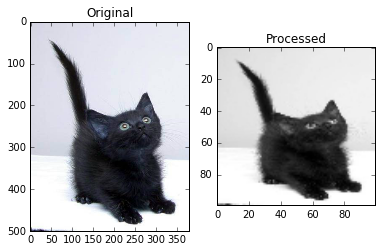

In [6]:
# an example of what the image look like now
count =0
imagePath = "cat.11132.jpg"
im = cv2.imread(imagePath)
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('Original')
plt.imshow(im)

image = turnGray(imagePath)
image = resizeImage(image, imagePath)

# what's the image look like now
plt.subplot(132)
plt.title('Processed')
plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

Secondly, set up training data set and testing data set in numeric matrice. 
In train_images/test_images, each line is a vector represents an image.
In train_labels/test_labels, each line is a number represents dog or cat.

In [34]:
def getLabel(imagePath):
    """Get the label of the image from its name where cat is -1, dog is 1."""
    if 'dog' in imagePath:
        return 1
    elif 'cat' in imagePath:
        return -1
    else:
        return 0
  

In [20]:
# set up data
count = 0
for imagePath in TRAIN_DIRS:
    image = turnGray(imagePath)
    image = resizeImage(image, imagePath)
    image = np.reshape(image, (1, IMAGE_LEN*IMAGE_WIDTH))
    label = getLabel(imagePath)
    train_images[count, :] = image
    train_labels[count] = label
    count += 1

In [23]:
# set up data in the test folder
count = 0
for imagePath in TEST_DIRS:
    image = turnGray(imagePath)
    image = resizeImage(image, imagePath)
    image = np.reshape(image, (1, IMAGE_LEN*IMAGE_WIDTH))
    #label = getLabel(imagePath)
    test_images[count, :] = image
    #test_labels[count] = label
    count += 1

In [7]:
# what the data looks like now?
print ('First 2 rows of train_images: ')
print train_images[:2, ]
print ("and the size is(should be 2*10000): ")
print (train_images[:2, ].shape)

print ('First 2 rows of train_labels: ')
print train_labels[:2, ]

First 2 rows of train_images: 
[[ 168.  173.  178. ...,    2.    2.    2.]
 [  44.   43.   43. ...,   91.   17.   34.]]
and the size is(should be 2*10000): 
(2, 10000)
First 2 rows of train_labels: 
[-1. -1.]


Lastly, shuffle and split data

In [21]:
# split train data into 75% training data and 25% testing data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

In [22]:
# check if the split is balanced on cats and dogs
count =0
for i in y_train:
    if i == -1:
        count += 1
print count
print y_train.shape

9391
(18750,)


In [23]:
# split training data into 80% training data and 20% validation data
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Part 2 Set up A Baseline

Define some funcitons for multiple implementation later.

In [4]:
def getMisclassificationRate(clf, X_train, X_test, y_train, y_test):
    '''Return the training misclassification rate and the testing misclassification rate.
       Input: the classifier clf, training features X_trian, testing features X_test,
              training labels y_train, testing labels y_test.
       Output: an array where first element is training misclassification rate, 
               the second element is validation misclassification rate,
               the third element is testing misclassification rate.'''
    
     # predict the model on training data to get the training error
    label_pred_training = clf.predict(X_train)
    # predict the model on test data to get the testing error
    label_pred = clf.predict(X_test)
    # this is the percentage that data is classified correctly
    mis_training = 1 - accuracy_score(y_train, label_pred_training)
    mis_validation = 1 - clf.best_score_
    mis_testing = 1 - accuracy_score(y_test, label_pred)
    
    return [mis_training, mis_validation, mis_testing]

In [5]:
def plotMisclassificationRate(xSize, xValue, yLowerSize, yUpperSize, xLabelName, title, testErr, trainErr, validationErr):
    '''Return the plot the misclassification rate of training data and testing data.
       Input: 
             xSize is the number of values on the x axis
             xValue is the possible values for parameters chosen to do cross validation
             yLowerSize is the lower bound value for y axis
             yUpperSize is the upper bound value for y axis
             xLabelName is the label name for x axis
             title is the title name for the plot
             testErr is the test error array where each element is the test error for a possible parameter value
             trainErr ......train ..................................train.......................................
             validationErr.. validation.................................validation..............................'''
    plt.figure(figsize=(22,10))
    ax=plt.gca()  
    ax.set_xticks(np.linspace(0,1,xSize))   
    ax.set_xticklabels(xValue)
    ax.set_ylim(yLowerSize, yUpperSize) 
    ax.set_xlabel(xLabelName)
    ax.set_ylabel('Misclassification rate')
    ax.set_title(title)
    plt.plot(np.linspace(0,1,xSize), testErr, 'r', label="testing error")
    plt.plot(np.linspace(0,1,xSize), validationErr, 'g', label="validation error")
    plt.plot(np.linspace(0,1,xSize), trainErr, 'b', label="training error")
    plt.legend(shadow=True, fancybox=True)
    plt.show()

Use only a portion of data to train classifiers in this part. 

In [24]:
# size of data used to be trained on in part 2
SUB_SIZE = 500

sub_X_train = X_train[:SUB_SIZE,]
sub_X_validation = X_validation[:SUB_SIZE,]
sub_y_train = y_train[:SUB_SIZE,]
sub_y_validation = y_validation[:SUB_SIZE,]

Give possible value range for the parameters

In [43]:
# RANGE_SIZE should be an even number
RANGE_SIZE = 40

# possible values for parameters are exp(i) where i from -RANGE_SIZE/2 to RANGE_SIZE/2
lis = np.zeros(RANGE_SIZE,)
count = 0
for i in range(-RANGE_SIZE/2, RANGE_SIZE/2):
    lis[count]=exp(i)
    count +=1

### Metrics

In [6]:
# set the metrics to misclassification rate
accuracy_scorer = make_scorer(accuracy_score)

### Train a linear kernel SVM classifier 

Random guess on the values of margin parameter

In [27]:
# C is margin parameter
tuned_parameters={'C': lis}

# grid search and cross validation
clf = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
clf.fit(sub_X_train, sub_y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  2.06115e-09,   5.60280e-09,   1.52300e-08,   4.13994e-08,
         1.12535e-07,   3.05902e-07,   8.31529e-07,   2.26033e-06,
         6.14421e-06,   1.67017e-05,   4.53999e-05,   1.23410e-04,
         3.35463e-04,   9.11882e-04,   2.47875e-03,   6.73795e-03,
         1.8315...,   1.20260e+06,   3.26902e+06,
         8.88611e+06,   2.41550e+07,   6.56600e+07,   1.78482e+08])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [29]:
bestC = clf.best_params_.get('C')
#bestGamma = clf.best_params_.get('gamma')
print ("Best value for C: ")
print bestC
print ("which is: ")
print ('exp('+ str(log(bestC)) + ')')

# get the misclassification rate on testing data
sub_y_pred = clf.predict(sub_X_validation)
misclassification = 1 - accuracy_score(sub_y_validation, sub_y_pred)
print ("Misclassification rate on validation data for linear kernel SVM: ")
print 1 - clf.best_score_
print ("Misclassification rate on testing data for linear kernel SVM: ")
print misclassification


Best value for C: 
4.13993771879e-08
which is: 
exp(-17.0)
Misclassification rate on validation data for linear kernel SVM: 
0.446
Misclassification rate on testing data for linear kernel SVM: 
0.456


Plot the misclassification rate for each possible value of C

In [30]:
training_rate = np.zeros(40,)
validation_rate = np.zeros(40,)
rate = np.zeros(40,)
i = 0

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for c in lis:
    tuned_parameters = {'C': [c]}
    clf1 = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf1.fit(sub_X_train, sub_y_train)
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf1, sub_X_train, sub_X_validation, sub_y_train, sub_y_validation)
    rate[i] = mis
    training_rate[i] = mis_training
    validation_rate[i] = mis_validation
    i +=1

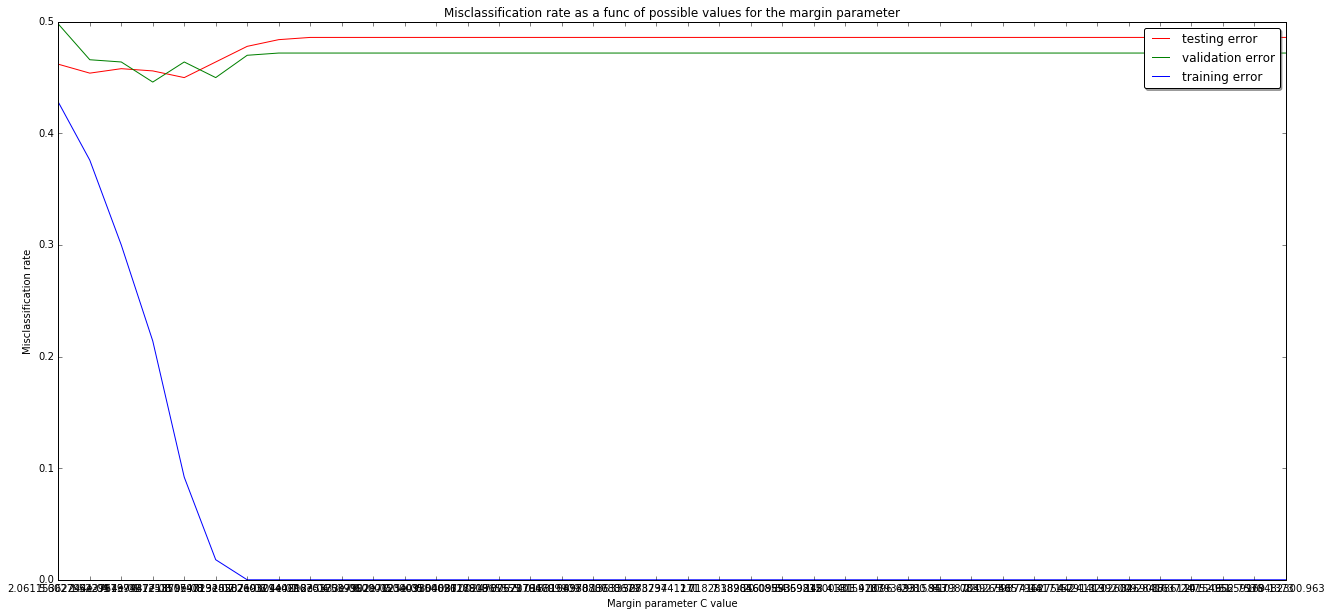

In [31]:
xLabelName = 'Margin parameter C value'
title = 'Misclassification rate as a func of possible values for the margin parameter'
plotMisclassificationRate(40, lis, 0, 0.5, xLabelName, title, rate, training_rate, validation_rate)

Zoom in the graph

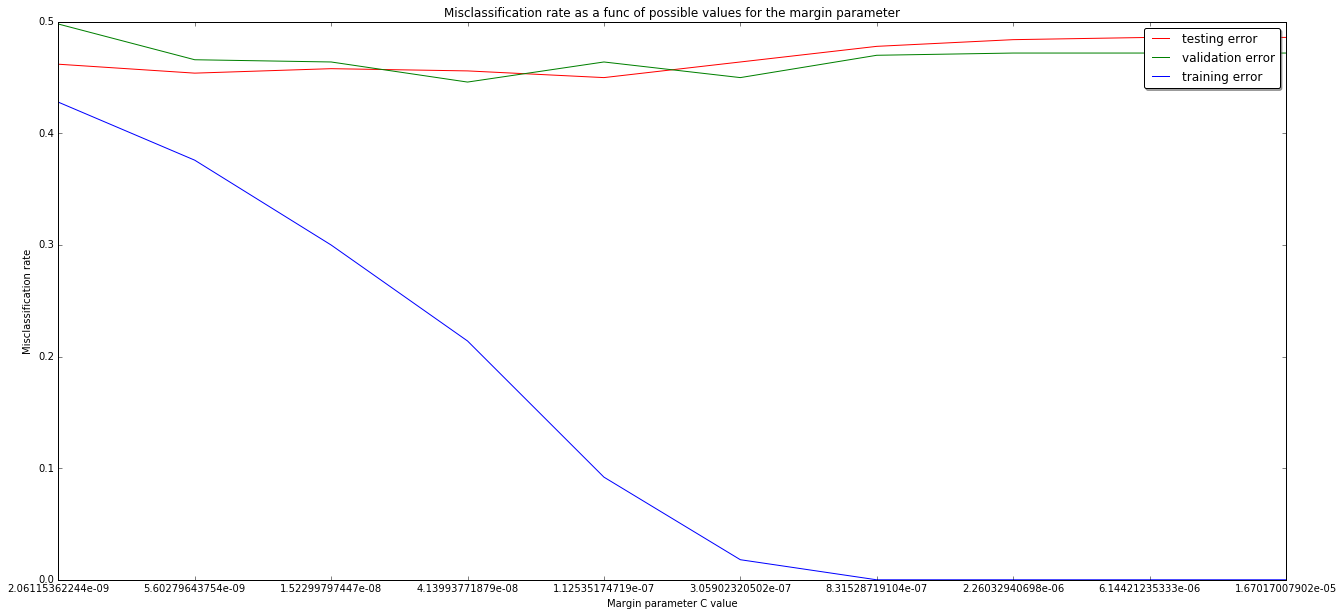

In [32]:
# plot the misclassification rate for first 10 possible values of margin parameter c which includes the optimal value  
plotMisclassificationRate(10, lis[:10], 0, 0.5, xLabelName, title, rate[:10], training_rate[:10], validation_rate[:10])

### Train a Random Forest classifier

In [33]:
# n_estimators is number of trees in the forest, max_features is number of axes in Rd
tuned_parameters={'n_estimators': [1, 10, 30, 50, 100, 500, 700, 1000],
    'max_features': ['auto', 'sqrt', 'log2']}

rf = RandomForestClassifier(oob_score = True) 

# grid search and cross validation
clfRF = GridSearchCV(rf, tuned_parameters, cv=5, scoring=accuracy_scorer)
clfRF.fit(sub_X_train, sub_y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 30, 50, 100, 500, 700, 1000], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [35]:
n_estimators = clfRF.best_params_.get('n_estimators')
max_features = clfRF.best_params_.get('max_features')
print ("Best value for n_estimators: ")
print n_estimators
print ("Best value for max_features: ")
print max_features

# get the misclassification rate on testing data
sub_y_pred = clfRF.predict(sub_X_validation)
misclassification = 1 - accuracy_score(sub_y_validation, sub_y_pred)
print ("Misclassification rate on validation data for Random Forest: ")
print 1- clfRF.best_score_
print ("Misclassification rate on testing data for Random Forest: ")
print misclassification

Best value for n_estimators: 
100
Best value for max_features: 
log2
Misclassification rate on validation data for Random Forest: 
0.408
Misclassification rate on testing data for Random Forest: 
0.42


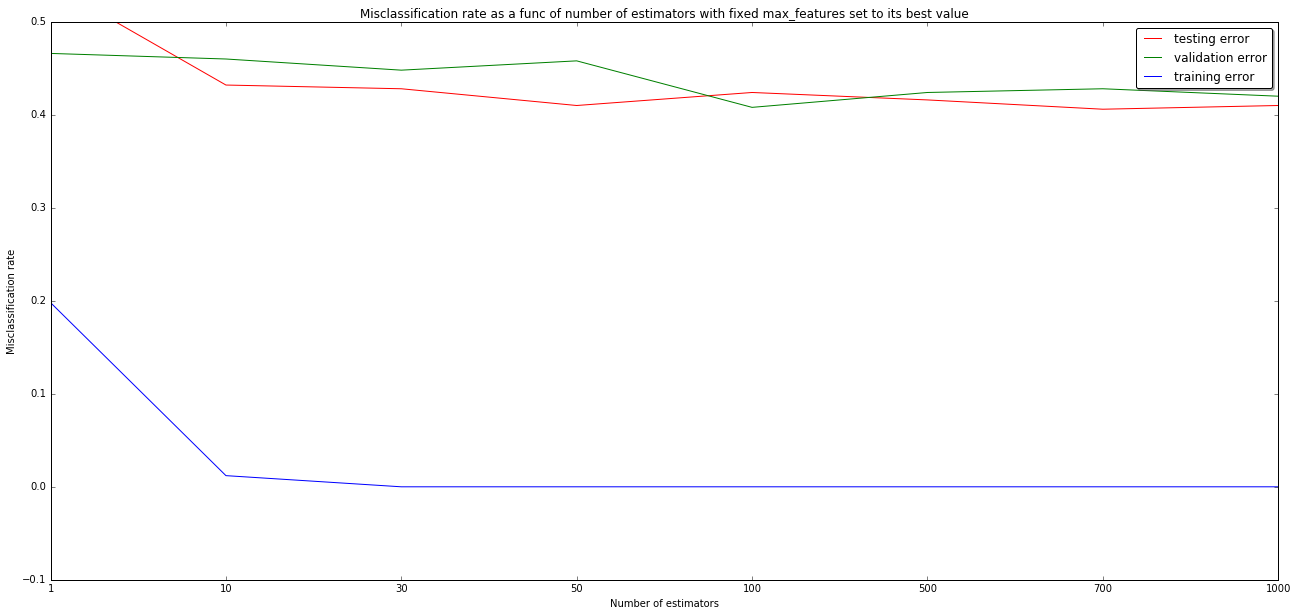

In [36]:
training_rate = np.zeros(8,)
rate = np.zeros(8,)
validation_rate = np.zeros(8,)
i = 0

n_estimators = [1, 10, 30, 50, 100, 500, 700, 1000]

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for n in n_estimators:
    tuned_parameters = {'n_estimators': [n]}
    clf2 = GridSearchCV(RandomForestClassifier(max_features=max_features,oob_score = True) , tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf2.fit(sub_X_train, sub_y_train)
    
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf2, sub_X_train, sub_X_validation, sub_y_train, sub_y_validation)
    rate[i] = mis
    validation_rate[i] = mis_validation
    training_rate[i] = mis_training
    i +=1

# plot the misclassification rate for training error and testing error
xLabelName = 'Number of estimators'
title = 'Misclassification rate as a func of number of estimators with fixed max_features set to its best value'
plotMisclassificationRate(8, n_estimators, -0.1, 0.5, xLabelName, title, rate, training_rate, validation_rate)

### Train an AdaBoost classifier

In [48]:
tuned_parameters= {'base_estimator__max_depth':[1,50],
          'base_estimator':[DecisionTreeClassifier(max_features=2), 
                            DecisionTreeClassifier(max_features=10)],
                  'n_estimators':[1, 10, 30, 50, 100, 500, 800, 1000, 1500]}

# grid search and cross validation
clfAB = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), tuned_parameters, cv=5, scoring=accuracy_scorer)
clfAB.fit(sub_X_train, sub_y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 30, 50, 100, 500, 800, 1000, 1500], 'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
 ...          presort=False, random_state=None, splitter='best')], 'base_estimator__max_depth': [1, 50]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_sco

In [49]:
n_estimators = clfAB.best_params_.get('n_estimators')
base_estimator = clfAB.best_params_.get('base_estimator')
base_estimator__max_depth = clfAB.best_params_.get('base_estimator__max_depth')
print ('Best value for base_estimator__max_depth: ')
print base_estimator__max_depth
print ("Best value for n_estimators: ")
print n_estimators
print (" ")
print ("Best value for base_estimator: ")
print base_estimator



# get the misclassification rate on testing data
sub_y_pred = clfAB.predict(sub_X_validation)
misclassification = 1 - accuracy_score(sub_y_validation, sub_y_pred)
print ("Misclassification rate on validation data for AdaBoost: ")
print 1 - clfAB.best_score_
print ("Misclassification rate on testing data for AdaBoost: ")
print misclassification

Best value for base_estimator__max_depth: 
50
Best value for n_estimators: 
1000
 
Best value for base_estimator: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Misclassification rate on validation data for AdaBoost: 
0.424
Misclassification rate on testing data for AdaBoost: 
0.474


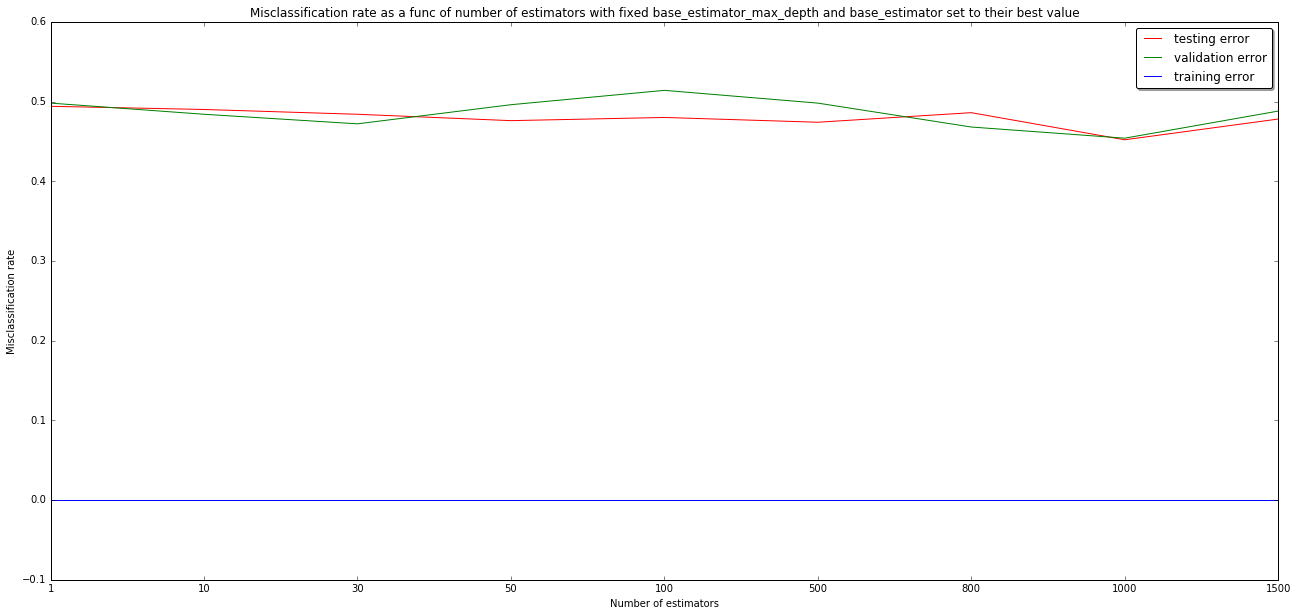

In [50]:
training_rate = np.zeros(9,)
rate = np.zeros(9,)
validation_rate = np.zeros(9,)
i = 0

n_estimators = [1, 10, 30, 50, 100, 500, 800, 1000, 1500]

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for n in n_estimators:
    tuned_parameters= {'base_estimator__max_depth':[base_estimator__max_depth],
                  'n_estimators':[n]}
    clf3 = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator), tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf3.fit(sub_X_train, sub_y_train)
    
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf3, sub_X_train, sub_X_validation, sub_y_train, sub_y_validation)
    rate[i] = mis
    validation_rate[i] = mis_validation
    training_rate[i] = mis_training
    i +=1

xLabelName = 'Number of estimators'
title = 'Misclassification rate as a func of number of estimators with fixed base_estimator_max_depth and base_estimator set to their best value'
plotMisclassificationRate(9, n_estimators, -0.1, 0.6, xLabelName, title, rate, training_rate, validation_rate)


### Estimation

Compare the performance of the 3 classifiers on the testing data and choose the classifier which has the lowest misclassification rate. 

In [51]:
# for SVM
y_pred_svm = clf.predict(X_test)
misclassification_svm = 1 - accuracy_score(y_test, y_pred_svm)
print 'Misclassification rate for linear SVM on the testing data: '
print misclassification_svm

# for Random Forest
y_pred_rf = clfRF.predict(X_test)
misclassification_rf = 1 - accuracy_score(y_test, y_pred_rf)
print 'Misclassification rate for Random Forest on the testing data: '
print misclassification_rf

# for AdaBoost
y_pred_ab = clfAB.predict(X_test)
misclassification_ab = 1 - accuracy_score(y_test, y_pred_ab)
print 'Misclassification rate for AdaBoost on the testing data: '
print misclassification_ab

Misclassification rate for linear SVM on the testing data: 
0.46032
Misclassification rate for Random Forest on the testing data: 
0.424
Misclassification rate for AdaBoost on the testing data: 
0.48624


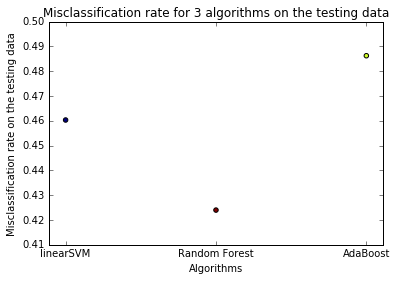

In [52]:
N = 3
y = np.array([misclassification_svm, misclassification_rf, misclassification_ab])
colors = np.random.rand(N)
ax=plt.gca()  
ax.set_xticks(np.linspace(0,1,3))   
ax.set_xticklabels(['linearSVM', 'Random Forest', 'AdaBoost'])
ax.set_xlabel('Algorithms')
ax.set_ylabel('Misclassification rate on the testing data')
ax.set_title('Misclassification rate for 3 algorithms on the testing data')
plt.scatter(np.linspace(0,1,3), y, c=colors)
plt.show()

### Conclusion

We choose Random Forest classifier with n_estimators = 100, max_features= 'auto' as the baseline. It has the lowest misclassification rate at 0.41488 among linearSVM, Random Forest and AdaBoost classifiers.

## Part 3 Train the classifier

Load pre-trained model Inception-v3 by tensorflow

In [31]:
def create_graph():
    with gfile.FastGFile(MODEL_DIR, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _=tf.import_graph_def(graph_def, name='')

In [32]:
def extract_features(images):
    #nb_features = IMAGE_LEN*IMAGE_WIDTH
    nb_features = 2048
    features = np.empty((len(images), nb_features))
    labels = []
    
    create_graph()
    
    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        for ind, image in enumerate(images):
            if(ind%100 ==0):
                print ('Processing %s...'%(image))
            if not gfile.Exists(image):
                    tf.logging.fatal('File does not exist %s', image)
        
            image_data = gfile.FastGFile(image,'rb').read()
            predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
            features[ind,:] = np.squeeze(predictions)
            labels.append(getLabel(image))
    
    return features, labels

In [18]:
#init_op = tf.initialize_all_variables()
features, labels = extract_features(TRAIN_DIRS)

Processing /Users/lordlavon/Desktop/input/train/cat.0.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10087.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10177.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10267.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10357.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10447.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10537.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10627.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10717.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10807.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10898.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.10988.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.11077.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.11167.jpg...
Processing /Users/lordlavon/Desktop/input/train/cat.11257.jpg...
Processing /Users/lordlavon/D

In [19]:
# save features and labels in files so that we don't have to run the code above every time restart the kernel
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

In [7]:
# load data from saved files
features = pickle.load(open('features'))
labels = pickle.load(open('labels'))

In [4]:
print ('Size of features: ')
print features.shape
print ('Size of labels: ')
print len(labels)

print ('Example of a feature data: ')
print features[1, :]

print ('Examples of label data: ')
print labels[:10]


Size of features: 
(25000, 2048)
Size of labels: 
25000
Example of a feature data: 
[ 0.40726197  0.52693456  0.83167541 ...,  0.14176303  0.41679356
  0.53065264]
Examples of label data: 
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [8]:
# seperate the data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state=42)
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

In [55]:
print features_train.shape

(15000, 2048)


### Train a linear kernel SVM classifier

In [56]:
# C is margin parameter
tuned_parameters={'C': lis[:10]}

# grid search and cross validation
clfSVM = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
clfSVM.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  2.06115e-09,   5.60280e-09,   1.52300e-08,   4.13994e-08,
         1.12535e-07,   3.05902e-07,   8.31529e-07,   2.26033e-06,
         6.14421e-06,   1.67017e-05])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [57]:
bestC = clfSVM.best_params_.get('C')
#bestGamma = clf.best_params_.get('gamma')
print ("Best value for C: ")
print bestC
print ("which is: ")
print ('exp('+ str(log(bestC)) + ')')


# get the misclassification rate on testing data
y_pred = clfSVM.predict(features_validation)
misclassification = 1 - accuracy_score(labels_validation, y_pred)
print ("Misclassification rate on validation data for linear kernel SVM: ")
print 1 - clfSVM.best_score_
print ("Misclassification rate on testing data for linear kernel SVM: ")
print misclassification

Best value for C: 
1.67017007902e-05
which is: 
exp(-11.0)
Misclassification rate on validation data for linear kernel SVM: 
0.0471333333333
Misclassification rate on testing data for linear kernel SVM: 
0.0541333333333


In [58]:
training_rate = np.zeros(10,)
rate = np.zeros(10,)
validation_rate = np.zeros(10,)
i = 0

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for c in lis[:10]:
    tuned_parameters = {'C': [c]}
    clf1 = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf1.fit(features_train, labels_train)
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf1, features_train, features_validation, labels_train, labels_validation)
    rate[i] = mis
    training_rate[i] = mis_training
    validation_rate[i] = mis_validation
    i +=1

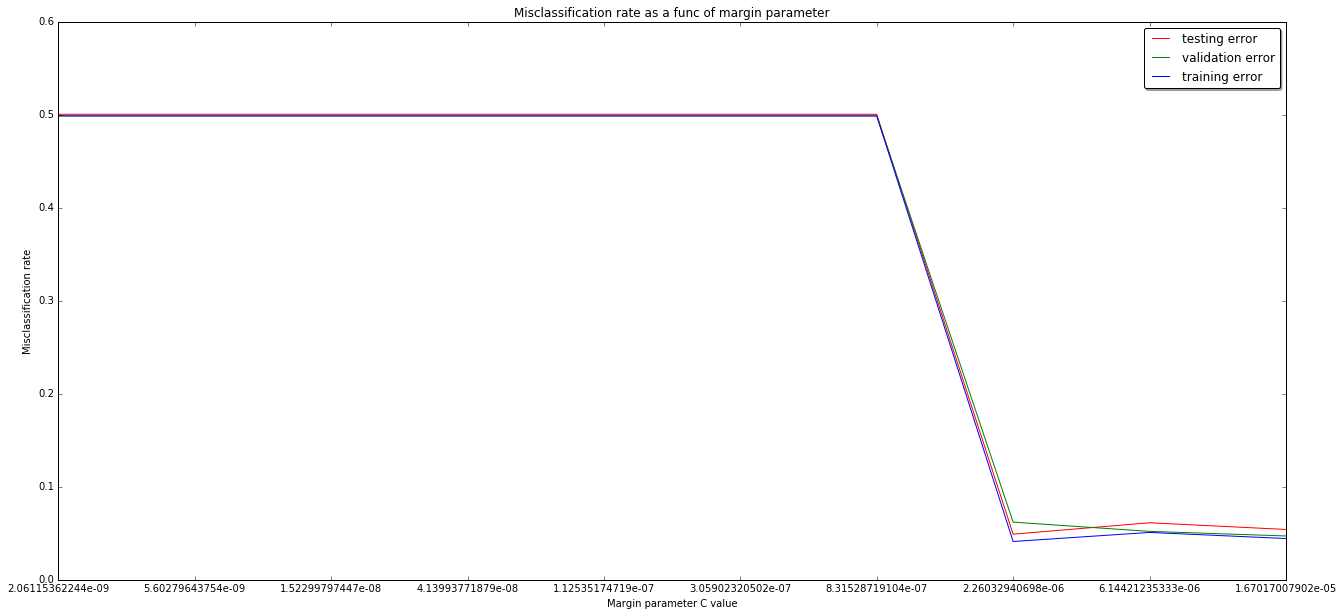

In [59]:
xLabelName = 'Margin parameter C value'
title = 'Misclassification rate as a func of margin parameter'
plotMisclassificationRate(10, lis[:10], 0, 0.6, xLabelName, title, rate, training_rate, validation_rate)

In [45]:
# C is margin parameter
tuned_parameters={'C': lis[9:14]}

# grid search and cross validation
clfSVM = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
clfSVM.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.67017e-05,   4.53999e-05,   1.23410e-04,   3.35463e-04,
         9.11882e-04])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [46]:
bestC = clfSVM.best_params_.get('C')
#bestGamma = clf.best_params_.get('gamma')
print ("Best value for C: ")
print bestC
print ("which is: ")
print ('exp('+ str(log(bestC)) + ')')


# get the misclassification rate on testing data
y_pred = clfSVM.predict(features_validation)
misclassification = 1 - accuracy_score(labels_validation, y_pred)
print ("Misclassification rate on validation data for linear kernel SVM: ")
print 1 - clfSVM.best_score_
print ("Misclassification rate on testing data for linear kernel SVM: ")
print misclassification

Best value for C: 
0.000911881965555
which is: 
exp(-7.0)
Misclassification rate on validation data for linear kernel SVM: 
0.0264
Misclassification rate on testing data for linear kernel SVM: 
0.0309333333333


In [47]:
# C is margin parameter
tuned_parameters={'C': lis[14:20]}

# grid search and cross validation
clfSVM = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
clfSVM.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.00248,  0.00674,  0.01832,  0.04979,  0.13534,  0.36788])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [48]:
bestC = clfSVM.best_params_.get('C')
#bestGamma = clf.best_params_.get('gamma')
print ("Best value for C: ")
print bestC
print ("which is: ")
print ('exp('+ str(log(bestC)) + ')')


# get the misclassification rate on testing data
y_pred = clfSVM.predict(features_validation)
misclassification = 1 - accuracy_score(labels_validation, y_pred)
print ("Misclassification rate on validation data for linear kernel SVM: ")
print 1 - clfSVM.best_score_
print ("Misclassification rate on testing data for linear kernel SVM: ")
print misclassification

Best value for C: 
0.00673794699909
which is: 
exp(-5.0)
Misclassification rate on validation data for linear kernel SVM: 
0.0242
Misclassification rate on testing data for linear kernel SVM: 
0.0312


In [49]:
training_rate = np.zeros(6,)
rate = np.zeros(6,)
validation_rate = np.zeros(6,)
i = 0

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for c in lis[14:20]:
    tuned_parameters = {'C': [c]}
    clf1 = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf1.fit(features_train, labels_train)
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf1, features_train, features_validation, labels_train, labels_validation)
    rate[i] = mis
    training_rate[i] = mis_training
    validation_rate[i] = mis_validation
    i +=1

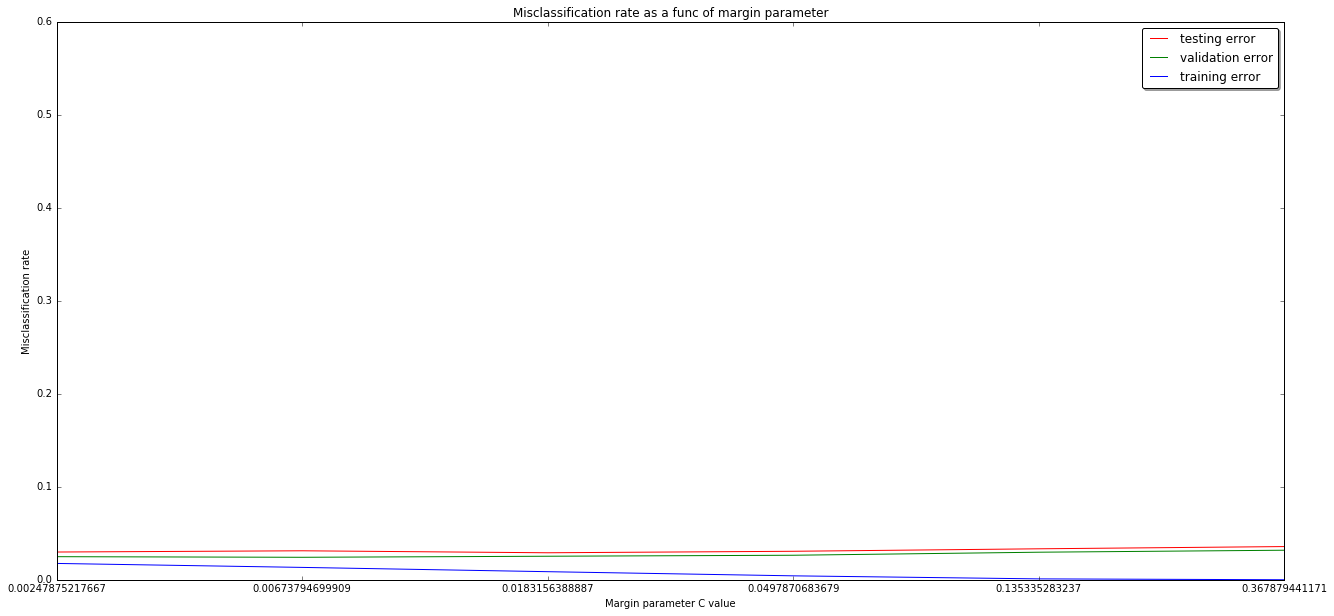

In [50]:
xLabelName = 'Margin parameter C value'
title = 'Misclassification rate as a func of margin parameter'
plotMisclassificationRate(6, lis[14:20], 0, 0.6, xLabelName, title, rate, training_rate, validation_rate)

In [54]:
print lis[14:20]
print validation_rate
print 'When c = exp(-5), the validation error is minimized which is 0.0242'

[ 0.00247875  0.00673795  0.01831564  0.04978707  0.13533528  0.36787944]
[ 0.02486667  0.0242      0.02533333  0.0264      0.02966667  0.0318    ]
When c = exp(-5), the validation error is minimized which is 0.0242


### Train a random Forest classifier

In [9]:
# n_estimators is number of trees in the forest, max_features is number of axes in Rd
tuned_parameters={'n_estimators': [1, 10, 30, 50, 100, 500, 700, 1000],
    'max_features': ['auto', 'sqrt', 'log2']}

rf = RandomForestClassifier(oob_score = True) 

# grid search and cross validation
clfRFp = GridSearchCV(rf, tuned_parameters, cv=5, scoring=accuracy_scorer)
clfRFp.fit(features_train, labels_train)

/Users/lordlavon/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/lordlavon/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:408: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 30, 50, 100, 500, 700, 1000], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [10]:
n_estimators = clfRFp.best_params_.get('n_estimators')
max_features = clfRFp.best_params_.get('max_features')
print ("Best value for n_estimators: ")
print n_estimators
print ("Best value for max_features: ")
print max_features

# get the misclassification rate on testing data
y_pred = clfRFp.predict(features_validation)
misclassification = 1 - accuracy_score(labels_validation, y_pred)
print ("Misclassification rate on validation data for Random Forest: ")
print 1 - clfRFp.best_score_
print ("Misclassification rate on testing data for Random Forest: ")
print misclassification

Best value for n_estimators: 
500
Best value for max_features: 
sqrt
Misclassification rate on validation data for Random Forest: 
0.0347333333333
Misclassification rate on testing data for Random Forest: 
0.0410666666667


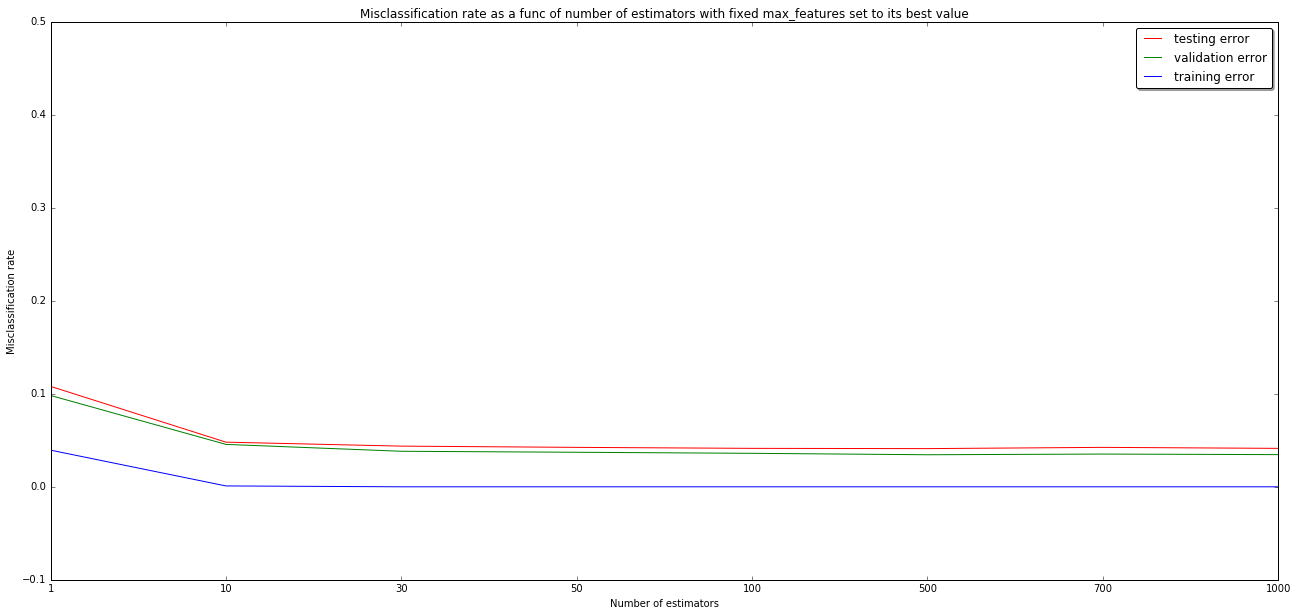

In [13]:
training_rate = np.zeros(8,)
rate = np.zeros(8,)
validation_rate = np.zeros(8,)
i = 0

n_estimators = [1, 10, 30, 50, 100, 500, 700, 1000]

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for n in n_estimators:
    tuned_parameters = {'n_estimators': [n]}
    clf2 = GridSearchCV(RandomForestClassifier(max_features=max_features,oob_score = True) , tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf2.fit(features_train, labels_train)
    
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf2, features_train, features_validation, labels_train, labels_validation)
    rate[i] = mis
    training_rate[i] = mis_training
    validation_rate[i] = mis_validation
    i +=1

# plot the misclassification rate for training error and testing error
xLabelName = 'Number of estimators'
title = 'Misclassification rate as a func of number of estimators with fixed max_features set to its best value'
plotMisclassificationRate(8, n_estimators, -0.1, 0.5, xLabelName, title, rate, training_rate, validation_rate)

Zoom in

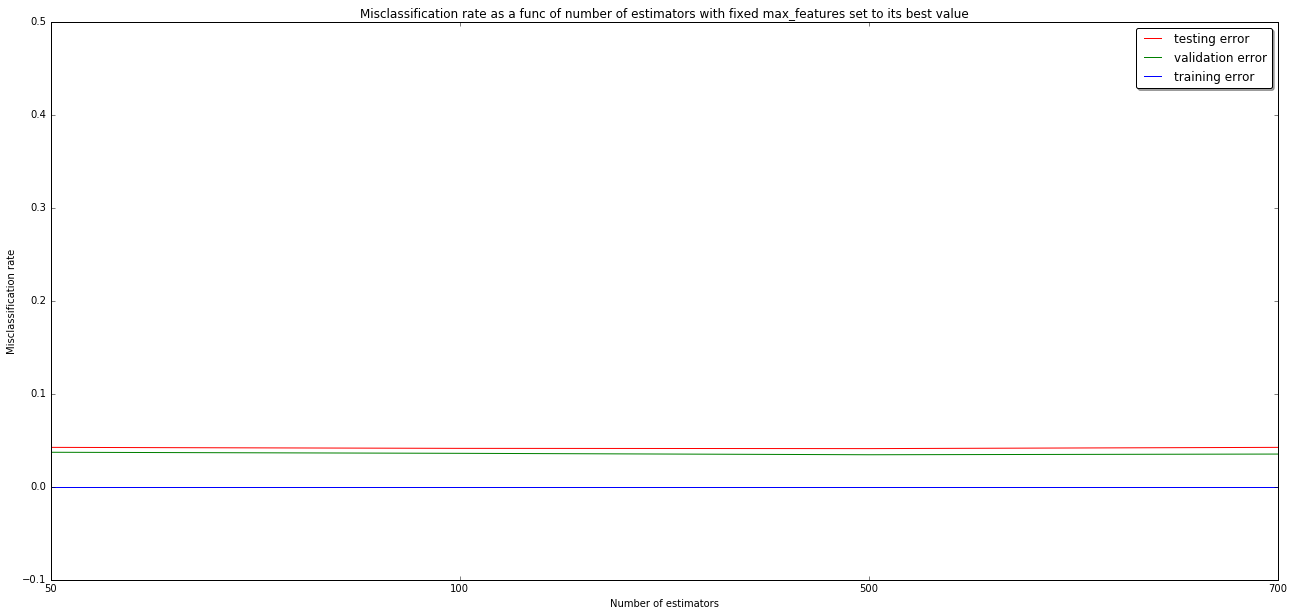

In [36]:
xLabelName = 'Number of estimators'
title = 'Misclassification rate as a func of number of estimators with fixed max_features set to its best value'
plotMisclassificationRate(4, n_estimators[3:7], -0.1, 0.5, xLabelName, title, rate[3:7], training_rate[3:7], validation_rate[3:7])

In [41]:
print n_estimators
print validation_rate
print 'When n_estimators = 500, the validation error is minimized which is 0.03446667'

[1, 10, 30, 50, 100, 500, 700, 1000]
[ 0.0982      0.0456      0.0382      0.03713333  0.036       0.03446667
  0.0352      0.0346    ]
When n_estimators = 500, the validation error is minimized which is 0.03446667


### Train an AdaBoost classifier

In [63]:
tuned_parameters= {'base_estimator__max_depth':[1],
          'base_estimator':[DecisionTreeClassifier(max_features=2), 
                            DecisionTreeClassifier(max_features=10)],
                   
                  'n_estimators':[1, 10, 30, 50, 100, 500, 800, 1000, 1500]}

# grid search and cross validation
clfABp = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), tuned_parameters, cv=5, scoring=accuracy_scorer)
clfABp.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1500], 'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_sta...,
            presort=False, random_state=None, splitter='best')], 'base_estimator__max_depth': [1]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_sco

In [64]:
n_estimators = clfABp.best_params_.get('n_estimators')
base_estimator = clfABp.best_params_.get('base_estimator')
base_estimator__max_depth = clfABp.best_params_.get('base_estimator__max_depth')
print ('Best value for base_estimator__max_depth: ')
print base_estimator__max_depth
print ("Best value for n_estimators: ")
print n_estimators
print (" ")
print ("Best value for base_estimator: ")
print base_estimator



# get the misclassification rate on testing data
y_pred = clfABp.predict(features_validation)
misclassification = 1 - accuracy_score(labels_validation, y_pred)
print ("Misclassification rate on validation data for AdaBoost: ")
print 1 - clfABp.best_score_
print ("Misclassification rate on testing data for AdaBoost: ")
print misclassification

Best value for base_estimator__max_depth: 
1
Best value for n_estimators: 
1500
 
Best value for base_estimator: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=10, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Misclassification rate on validation data for AdaBoost: 
0.123066666667
Misclassification rate on testing data for AdaBoost: 
0.138666666667


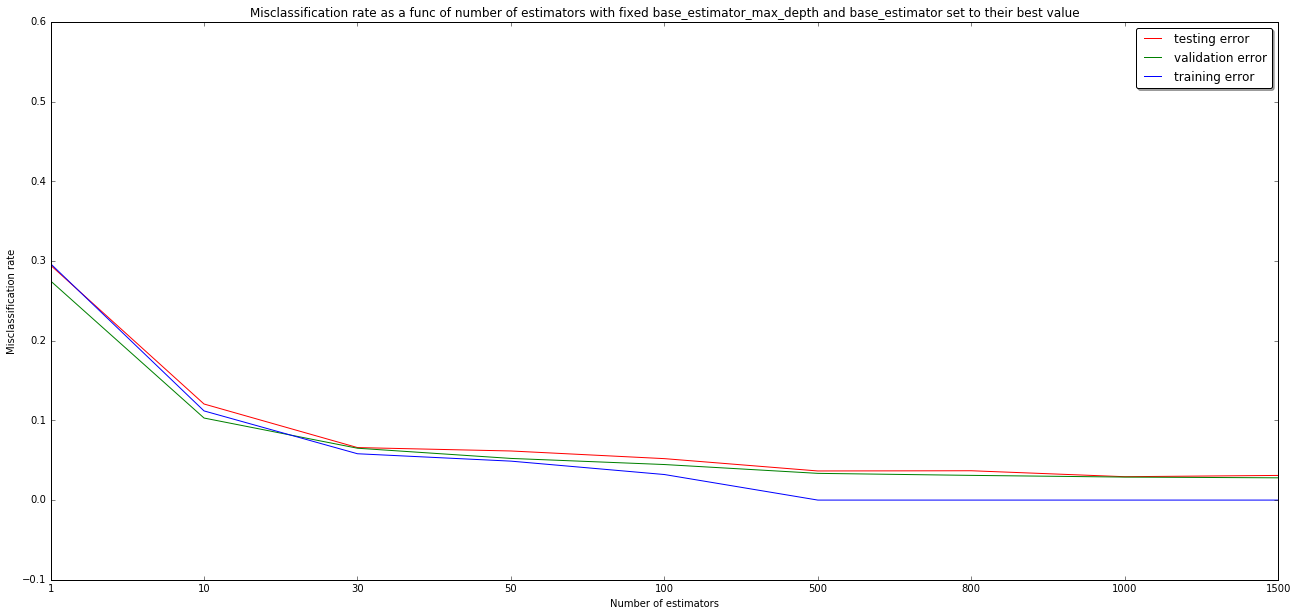

In [86]:
training_rate = np.zeros(9,)
rate = np.zeros(9,)
validation_rate = np.zeros(9,)
i = 0

n_estimators = [1, 10, 30, 50, 100, 500, 800, 1000, 1500]

# use cross-validation for each possible C value to get the corresponding misclassification rate
# by iterating the possible value of c
for n in n_estimators:
    tuned_parameters= {'base_estimator__max_depth':[base_estimator__max_depth],
                  'n_estimators':[n]}
    clf3 = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator), tuned_parameters, cv=5, scoring=accuracy_scorer)
    clf3.fit(features_train, labels_train)
    
    [mis_training, mis_validation, mis] = getMisclassificationRate(clf3, features_train, features_validation, labels_train, labels_validation)
    rate[i] = mis
    validation_rate[i] = mis_validation
    training_rate[i] = mis_training
    i +=1

xLabelName = 'Number of estimators'
title = 'Misclassification rate as a func of number of estimators with fixed base_estimator_max_depth and base_estimator set to their best value'
plotMisclassificationRate(9, n_estimators, -0.1, 0.6, xLabelName, title, rate, training_rate, validation_rate)


### Estimation

In [65]:
# for SVM
y_pred_svm = clfSVM.predict(features_test)
misclassification_svm = 1 - accuracy_score(labels_test, y_pred_svm)
print 'Misclassification rate for linear SVM on the testing data: '
print misclassification_svm

# for Random Forest
y_pred_rf = clfRFp.predict(features_test)
misclassification_rf = 1 - accuracy_score(labels_test, y_pred_rf)
print 'Misclassification rate for Random Forest on the testing data: '
print misclassification_rf

# for AdaBoost
y_pred_ab = clfABp.predict(features_test)
misclassification_ab = 1 - accuracy_score(labels_test, y_pred_ab)
print 'Misclassification rate for AdaBoost on the testing data: '
print misclassification_ab

Misclassification rate for linear SVM on the testing data: 
0.02592
Misclassification rate for Random Forest on the testing data: 
0.03616
Misclassification rate for AdaBoost on the testing data: 
0.12832


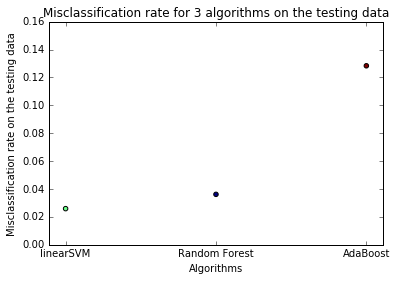

In [66]:
N = 3
y = np.array([misclassification_svm, misclassification_rf, misclassification_ab])
colors = np.random.rand(N)
ax=plt.gca()  
ax.set_xticks(np.linspace(0,1,3))   
ax.set_xticklabels(['linearSVM', 'Random Forest', 'AdaBoost'])
ax.set_xlabel('Algorithms')
ax.set_ylabel('Misclassification rate on the testing data')
ax.set_title('Misclassification rate for 3 algorithms on the testing data')
plt.scatter(np.linspace(0,1,3), y, c=colors)
plt.show()

### Conclusion

Clearly, linear SVM has a better performance. It has the lowest misclassification rate on the leave-out testing data at 0.02592 among linear SVM, Random Forest and AdaBoost classifiers and 0.02592 is much lower than the misclassification rate of the baseline which is 0.424.We choose the linear SVM classifier to be our optimal classifier where c=exp(-5).

In [67]:
classifier = clfSVM

In [71]:
def isDogOrCat(imagePath):
    image = cv2.imread(imagePath)
    plt.figure()
    plt.title('Predicted image')
    plt.imshow(image)
    plt.show()
    feature, fakeLabel = extract_features([imagePath])
    result = classifier.predict(feature)
    
    if result == 1:
        return 'This is more like a dog image.'
    elif result == -1: 
        return 'This is more like a cat image.'
    else:
        print 'Whoops! This is weird, I do not know what this image is'
    

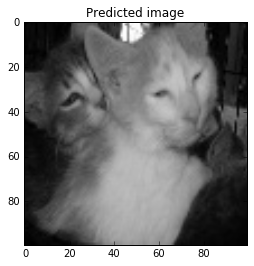

Processing /Users/lordlavon/Desktop/input/test/16.jpg...


'This is more like a cat image.'

In [72]:
# implement with some other images
imagePath = '/Users/lordlavon/Desktop/input/test/16.jpg'

isDogOrCat(imagePath)

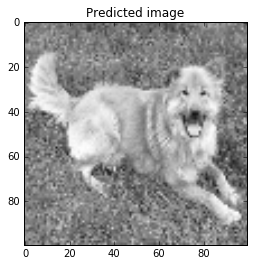

Processing /Users/lordlavon/Desktop/input/test/4.jpg...


'This is more like a dog image.'

In [73]:
imagePath = '/Users/lordlavon/Desktop/input/test/4.jpg'

isDogOrCat(imagePath)